In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from PIL import Image, ExifTags
import uuid
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from scipy.spatial import distance 
from sklearn.metrics import pairwise_distances
from numba import jit, prange
from concurrent.futures import ProcessPoolExecutor

from scipy.spatial import distance
from sklearn.metrics import pairwise
import time
import sqlite3
import pickle

import torch
from torchvision import models, transforms

# Retrival Pipeline

In [2]:
'''
Load all image paths and get the total number of images,
we can't use tqdm here, because we have to determine the number of images first.
'''

def find_image_files(root_dir, extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')):
    image_files = []
    
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(extensions):
                image_files.append(os.path.join(subdir, file))
    return image_files


# here was: image_paths = find_image_files(r"")
# df_image_paths = pd.DataFrame({'ID': range(1, len(image_paths) + 1), 'Path': image_paths})
# df_image_paths = pd.DataFrame(image_paths, columns=["Path"])
# df_image_paths.to_pickle('Path.pkl')


# Show first 10 paths
# print(f"Number found images: {len(image_paths)}")
# if len(image_paths) > 10:
#     print("Some paths:")
#     for pic_path in image_paths[:10]:
#         print(pic_path)
# else:
#     print("Found paths:", image_paths)

In [3]:
# Measurement functions

def image_rgb_calculation(image):
    # OpenCV uses BGR color space, we have to convert it to the RGB color space
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate the histogram
    hist = cv2.calcHist([rgb_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    
    # Normalize the histogram so that histograms of different images (different sizes, resolutions) are comparable
    hist = cv2.normalize(hist, hist)
    hist = hist.flatten()
    return hist


def image_hsv_calculation(image):
    # OpenCV uses BGR color space, we have to convert it to the RGB color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calculate the histogram (bin-sizes = 8, values from 0-255)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    
    # Normalize the histogram so that histograms of different images (different sizes, resolutions) are comparable
    hist = cv2.normalize(hist, hist)
    hist = hist.flatten()
    return hist


# Load the efficientnet_v2_s model
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

# Remove last layer (classificator), because we only need the features
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def model_embeddings_calculation(image):
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    with torch.no_grad():
        features = model(input_batch)
    features = torch.flatten(features, 1)
    
    return features.numpy().flatten()

In [4]:
%%time


def extract_image_details(image_id, path, resize_size):
    try:
        image = cv2.imread(path)
        if image is not None:
            image = cv2.resize(image, resize_size)
            rgb_histogram = image_rgb_calculation(image)
            hsv_histogram = image_hsv_calculation(image)
            model_embedding = model_embeddings_calculation(image)
            
            ### several more informations ###
            
            # Convert to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Calculate average color and brightness
            avg_color = np.mean(image_rgb, axis=(0, 1)).tolist()
            avg_brightness = np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

            # Convert to HSV and calculate average HSV
            image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            avg_hsv = np.mean(image_hsv, axis=(0, 1)).tolist()

            # File details
            file_size = os.path.getsize(path)
            file_type = os.path.splitext(path)[1]

            with Image.open(path) as img:
                # Resolution and DPI
                resolution = img.size  # (width, height)
                dpi = img.info.get('dpi', (0, 0))
                
                # Extract metadata
                try:
                    exif_data = img._getexif()
                    metadata = {ExifTags.TAGS.get(k, k): v for k, v in exif_data.items()} if exif_data else {}
                except AttributeError:
                    metadata = {}
            
            
            #################################
            
            
            return {
                'ID': image_id,
                'Path': path,
                'RGB_Histogram': rgb_histogram,
                'HSV_Histogram': hsv_histogram,
                'Model_Embedding': model_embedding,
                'Average_Color': avg_color,
                'Brightness': avg_brightness,
                'Average_HSV': avg_hsv,
                'Resolution': resolution,
                'DPI': dpi,
                'File_Size': file_size,
                'File_Type': file_type,
                'Metadata': metadata
            }
        
        else:
            print(f"Image at path {path} is None.")
            return None
        
    except Exception as e:
        print(f"Failed processing {path}: {e}")
        return None

    
def load_checkpoint():
    if not os.path.exists('checkpoint.pkl'):
        return 0, [], [], [], [], []
    
    with open('checkpoint.pkl', 'rb') as f:
        batch_index, paths, rgb_hists, hsv_hists, embeddings, other_data = pickle.load(f)
        print(f"Loaded checkpoint.\nStarting from path with ID: {batch_index + 1}")

    return batch_index, paths, rgb_hists, hsv_hists, embeddings, other_data
    
    

def image_batch_generator(image_files, batch_size, resize_size, start_index = 0, show_progress=True):
    total_batches = (len(image_files) - start_index + batch_size - 1) // batch_size # - start_index to display remaining batches correctly
    progress_bar = tqdm(total=total_batches, desc="Processing images") if show_progress else None

    for index in range(start_index, len(image_files), batch_size):
        batch = image_files[index:index + batch_size]
        details_list = [extract_image_details(index + i + 1, path, resize_size) for i, path in enumerate(batch)]
        details_list = [features for features in details_list if features is not None]
        df = pd.DataFrame(details_list)
        yield df, index + batch_size
        if show_progress:
            progress_bar.update(1)

    if show_progress:
        progress_bar.close()

        
        
# Testing: Example
batch_size = 1000
desired_size = (224, 224)


# Load checkpoint
start_index, paths, rgb_hists, hsv_hists, embeddings, other_data = load_checkpoint()

image_paths = find_image_files(r"C:\Users\timsa\Desktop\Daten_Joschua\data\image_data\extra_collection\city")

for df, batch_index in image_batch_generator(image_paths, batch_size, desired_size, start_index=start_index, show_progress=True):
    paths.extend(df[['ID', 'Path']].values.tolist())
    rgb_hists.extend(df[['ID', 'RGB_Histogram']].values.tolist())
    hsv_hists.extend(df[['ID', 'HSV_Histogram']].values.tolist())
    embeddings.extend(df[['ID', 'Model_Embedding']].values.tolist())
    other_data.extend(df.drop(columns=['Path', 'RGB_Histogram', 'HSV_Histogram', 'Model_Embedding']).values.tolist())
    
    # Save checkpoint, overrides old one and appends new data
    with open('checkpoint.pkl', 'wb') as f:
        pickle.dump((batch_index, paths, rgb_hists, hsv_hists, embeddings, other_data), f)
    

# Save results
df_paths = pd.DataFrame(paths, columns=["ID", "Path"])
df_rgb = pd.DataFrame(rgb_hists, columns=["ID", "Histogram"])
df_hsv = pd.DataFrame(hsv_hists, columns=["ID", "Histogram"])
df_embeddings = pd.DataFrame(embeddings, columns=["ID", "Embedding"])
df_other_data = pd.DataFrame(other_data, columns=["ID", "Average_Color",
                                                 "Brightness", "Average_HSV",
                                                 "Resolution","DPI",
                                                 "File_Size", "File_Type",
                                                 "Metadata"
                                                ])

df_paths.to_pickle('Path.pkl')
df_rgb.to_pickle('RGB_Hist.pkl')
df_hsv.to_pickle('HSV_Hist.pkl')
df_embeddings.to_pickle('Embedding.pkl')
df_other_data.to_pickle('Other_data.pkl')

# Checkpoint can be removed after program was successful
if os.path.exists('checkpoint.pkl'):
    os.remove('checkpoint.pkl')

Processing images:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 5min 23s
Wall time: 1min 12s


In [63]:
len(df_rgb)

2056

In [64]:
print(df_embeddings.tail())

        ID                                          Embedding
2051  2052  [-0.20513535, -0.10810962, -0.23736508, -0.231...
2052  2053  [-0.19108932, 1.7732646, -0.20176479, -0.16974...
2053  2054  [-0.011624885, 0.011469968, -0.16959248, -0.23...
2054  2055  [-0.15407062, 0.28345406, -0.1295455, -0.14643...
2055  2056  [-0.18163215, 0.6147414, -0.068714134, -0.2097...


In [65]:
first_histogram_length = len(df_embeddings.iloc[0]['Embedding'])
first_histogram_length

1280

In [66]:
print(df_rgb.tail())
print(df_hsv.tail())
print(df_paths.tail())
print(df_other_data.tail())

        ID                                          Histogram
2051  2052  [0.04886454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
2052  2053  [0.5030495, 0.41761094, 0.0, 0.0, 0.0, 0.0, 0....
2053  2054  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2054  2055  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2055  2056  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
        ID                                          Histogram
2051  2052  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2052  2053  [0.041315034, 0.004804074, 0.003843259, 0.0057...
2053  2054  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2054  2055  [0.0, 0.0, 0.0, 0.0, 0.0007018793, 0.006316913...
2055  2056  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0038390239, 0.0665...
        ID                                               Path
2051  2052  C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
2052  2053  C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
2053  2054  C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
2054  20

In [4]:
# Create database

# Check if the folder 'databases' does not exist / create it
if not os.path.exists('database'):
    os.makedirs('database')
    
conn = sqlite3.connect("database/bd_database.db")
curs = conn.cursor()

curs.execute("""CREATE TABLE IF NOT EXISTS image_paths 
                (ID INTEGER PRIMARY KEY,
                Path text);""")
conn.commit()

In [5]:
# Save data to database
path_pickle_df = pd.read_pickle("Path.pkl")

for file_path in path_pickle_df['Path']:
    curs.execute('''INSERT OR IGNORE INTO image_paths (Path) VALUES (?);''', (file_path,))
    # print(f"Inserted path: {file_path}")
    
conn.commit()

In [6]:
curs.execute("""SELECT *
                FROM image_paths;""")
results = curs.fetchall()

df = pd.DataFrame(results, columns=['ID', 'Path'])

#conn.close()

df

,ID,Path
0,1,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
1,2,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
2,3,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
3,4,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
4,5,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
...,...,...
2051,2052,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
2052,2053,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
2053,2054,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...
2054,2055,C:\Users\timsa\Desktop\Daten_Joschua\data\imag...


In [22]:
# Similarity functions

def euclidean_distance():
    pass

def manhattan_distance():
    pass

def cosine_similarity():
    pass

def jaccard_similarity():
    pass

def hamming_distance():
    pass


# Testing Similarities

In [66]:
resize_size = (224, 224)
input_images_number = 5
#max_id = df['ID'].max()
max_id=99

In [67]:
if input_images_number == 1:
    input_images = [r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_1.jpg"]
else: 
    input_images = [
        r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_1.jpg",
        r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_2.jpg",
        r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_3.jpg",
        r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_4.jpg",
        r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_5.jpg"
    ]
    
#same image is: cheng-feng-psdV2Rl-GvU-unsplash.jpg

In [58]:
details_list = [extract_image_details(max_id + i + 1, path, resize_size) for i, path in enumerate(input_images)]
details_list = [features for features in details_list if features is not None]
df_input = pd.DataFrame(details_list)
#df_input.to_pickle('Input.pkl')
df_input


,ID,Path,RGB_Histogram,HSV_Histogram,Model_Embedding,Average_Color,Brightness,Average_HSV,Resolution,DPI,File_Size,File_Type,Metadata
0,2057,C:\Users\timsa\Desktop\sample_pictures\testing...,"[0.6106335, 0.5034046, 0.15748051, 0.057104133...","[0.0005863362, 0.0, 0.0, 0.0, 0.0, 0.001759008...","[0.8181913, 0.39032054, 0.6609789, -0.13837864...","[97.40706712372449, 65.04257015306122, 125.264...",81.582968,"[116.24613360969387, 189.73674665178572, 151.8...","(1280, 1920)","(0, 0)",188408,.jpg,{}


In [59]:
# Load pickles
rgb_df = pd.read_pickle("RGB_Hist.pkl")
hsv_df = pd.read_pickle("HSV_Hist.pkl")
embedding_df = pd.read_pickle("Embedding.pkl")


In [63]:
measurement = "Embedding"
similarity = "euclidean_distance"
best_n = 5

similarities = []

if measurement == "RGB":
    df_input_rgb = df_input[['ID', 'RGB_Histogram']]
    
    if similarity == "euclidean_distance":
        similarities = euclidean_distance(df_input_rgb, rgb_df, best_n)
        
    elif similarity == "manhattan_distance":
        similarities = manhattan_distance(df_input_rgb, rgb_df, best_n)
        
    elif similarity == "cosine_similarity":
        similarities = cosine_similarity(df_input_rgb, rgb_df, best_n)
        
    elif similarity == "jaccard_similarity":
        similarities = jaccard_similarity(df_input_rgb, rgb_df, best_n)
        
    elif similarity == "hamming_distance":
        similarities = hamming_distance(df_input_rgb, rgb_df, best_n)

        
elif measurement == "HSV":
    df_input_hsv = df_input[['ID', 'HSV_Histogram']]
    
    if similarity == "euclidean_distance":
        similarities = euclidean_distance(df_input_hsv, hsv_df, best_n)
        
    elif similarity == "manhattan_distance":
        similarities = manhattan_distance(df_input_hsv, hsv_df, best_n)
        
    elif similarity == "cosine_similarity":
        similarities = cosine_similarity(df_input_hsv, hsv_df, best_n)
        
    elif similarity == "jaccard_similarity":
        similarities = jaccard_similarity(df_input_hsv, hsv_df, best_n)
        
    elif similarity == "hamming_distance":
        similarities = hamming_distance(df_input_hsv, hsv_df, best_n)
    
    
elif measurement == "Embedding":
    df_input_embedding = df_input[['ID', 'Model_Embedding']]
    
    if similarity == "euclidean_distance":
        similarities = euclidean_distance(df_input_embedding, embedding_df, best_n)
        
    elif similarity == "manhattan_distance":
        similarities = manhattan_distance(df_input_embedding, embedding_df, best_n)
        
    elif similarity == "cosine_similarity":
        similarities = cosine_similarity(df_input_embedding, embedding_df, best_n)
        
    elif similarity == "jaccard_similarity":
        similarities = jaccard_similarity(df_input_embedding, embedding_df, best_n)
        
    elif similarity == "hamming_distance":
        similarities = hamming_distance(df_input_embedding, embedding_df, best_n)



In [109]:
# Example list for testing
similarities = [6, 20, 50, 175, 200]

In [110]:
results_paths = []
for image_id in similarities:
    curs.execute("""SELECT path
                    FROM image_paths
                    WHERE ID == (?);""", (image_id,))
    results = curs.fetchall()
    
    # If there are results save only the path (otherwise the output would be lists with tuples)
    if results:
        results_paths.append(results[0][0])

In [111]:
results

[('C:\\Users\\timsa\\Desktop\\Daten_Joschua\\data\\image_data\\DIV2k\\DIV2K_train_HR\\DIV2K_train_HR\\0200.png',)]

In [112]:
results_paths

['C:\\Users\\timsa\\Desktop\\Daten_Joschua\\data\\image_data\\DIV2k\\DIV2K_train_HR\\DIV2K_train_HR\\0006.png',
 'C:\\Users\\timsa\\Desktop\\Daten_Joschua\\data\\image_data\\DIV2k\\DIV2K_train_HR\\DIV2K_train_HR\\0020.png',
 'C:\\Users\\timsa\\Desktop\\Daten_Joschua\\data\\image_data\\DIV2k\\DIV2K_train_HR\\DIV2K_train_HR\\0050.png',
 'C:\\Users\\timsa\\Desktop\\Daten_Joschua\\data\\image_data\\DIV2k\\DIV2K_train_HR\\DIV2K_train_HR\\0175.png',
 'C:\\Users\\timsa\\Desktop\\Daten_Joschua\\data\\image_data\\DIV2k\\DIV2K_train_HR\\DIV2K_train_HR\\0200.png']

In [55]:
for path in results:
    image = Image.open(path)
    print(path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

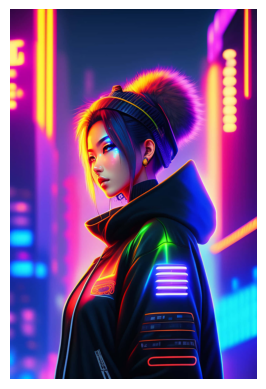

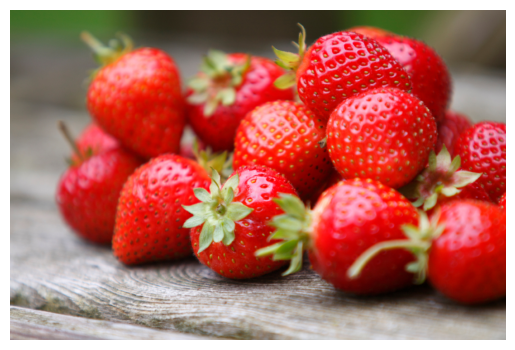

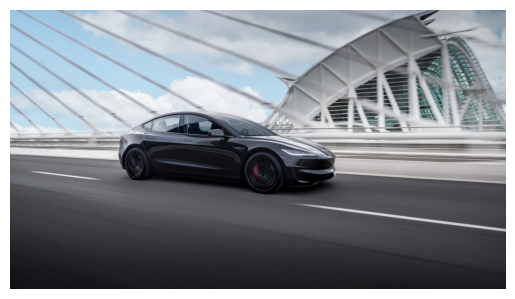

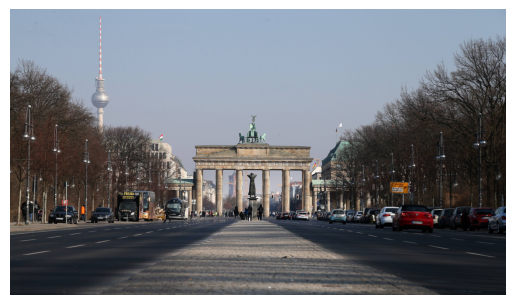

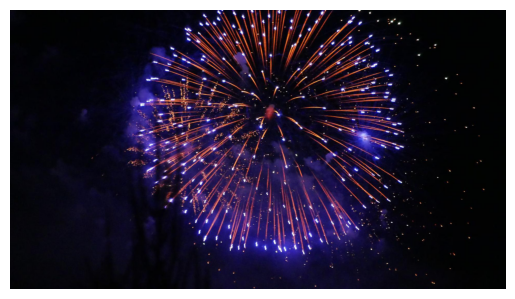

In [68]:
for path in input_images:
    image = Image.open(path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

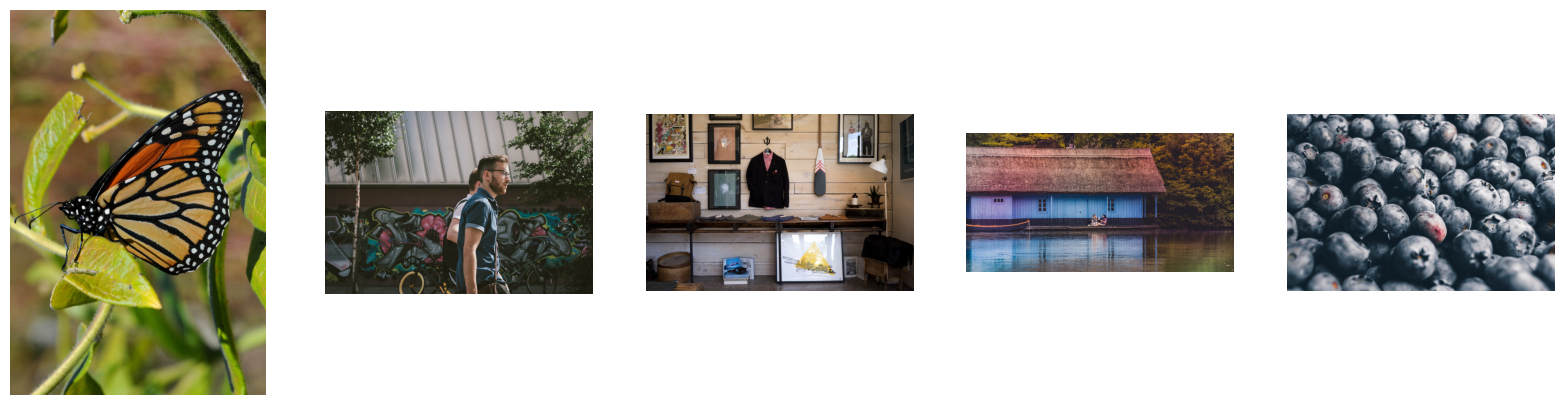

In [113]:
# Subplots
fig, axes = plt.subplots(1, input_images_number, figsize=(20, 5))

for i, path in enumerate(results_paths):
    image = Image.open(path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

# ___________________________________________________